In [2]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.signal as sp
import os
from google.colab import files
import shutil
if not os.path.exists("Results"):
  os.mkdir("Results") 
path = '/content/speech.wav'
basePath = 'Results/'

In [3]:
class LPCVocoder:

  def __init__(self,path, frameLengthInSecond, filterOrder, start, stop): #initializations
    self.x , self.fs = sf.read(path)
    if len(self.x.shape) > 1: # if sound has two channel, use the first
      self.x = self.x[:,0]
    self.totalTime = len(self.x)/self.fs
    self.startingIndex = int(np.ceil(self.fs*start))
    self.stopIndex = int(np.floor(self.fs*stop))
    self.x = self.x[self.startingIndex:self.stopIndex] # cutting desired part
    self.x = self.x/np.max(np.abs(self.x))
    self.L = frameLengthInSecond
    self.frameLength = np.int(np.floor(self.L*self.fs)) #secon to sample conversion
    self.soundLength = len(self.x)
    self.totalTime = self.soundLength/self.fs
    self.frameCount = np.int(np.floor(self.soundLength/self.frameLength)) #total number of frames
    self.pitchPer = np.zeros(self.soundLength)
    self.pitchFreq = np.zeros(self.soundLength)
    self.voice = np.zeros(self.soundLength)
    self.p = filterOrder
    self.decodedSpeech = np.zeros(self.soundLength)
    self.hammingWindow = np.hamming(self.frameLength) # hamming
    self.title = basePath + os.path.basename(path) + "_" + str(frameLengthInSecond) + "_sec_" + str(filterOrder) + "_order_"
    sf.write(self.title + "cuttedSpeech.wav", self.x,self.fs)


  def pitchDetectionAndVoicedDecision(self):
      for i in range(self.frameCount):
        self.x[i*self.frameLength:(i+1)*self.frameLength] = self.x[i*self.frameLength:(i+1)*self.frameLength]*self.hammingWindow # hamming is applied
        y = self.x[i*self.frameLength:(i+1)*self.frameLength]
        indices = [k for k in range(1,len(y)-1) if y[k-1]<0 and y[k]>=0]
        cross = [k - (y[k] / (y[k+1] - y[k])) for k in indices]
        diff=np.diff(cross)
        goodFreq = [d for d in diff if (self.fs/d)>=30 and (self.fs/d)<=500]
        if goodFreq:
          self.pitchFreq[i*self.frameLength:(i+1)*self.frameLength] = self.fs / np.mean(goodFreq)
          self.pitchPer[i*self.frameLength:(i+1)*self.frameLength] = np.mean(goodFreq)
          self.voice[i*self.frameLength:(i+1)*self.frameLength]=1
        else:
          self.voice[i*self.frameLength:(i+1)*self.frameLength]=0

  def coefAndGainComputation(self):
    state = np.zeros(self.p)
    e = np.zeros(self.soundLength) #prediction error variable initialization
    self.coefficients = np.zeros((self.frameCount,self.p))
    self.transferFunctionOverall = np.zeros((self.frameCount,self.p+1))
    self.gain = np.zeros(self.frameCount)


    for m in range(0,self.frameCount):
        A = np.zeros((self.frameLength-self.p,self.p))
        for n in range(0,self.frameLength-self.p):
            A[n,:] = self.x[m*self.frameLength+n+np.arange(self.p-1,-1,-1)]
        #Construct our desired target signal d, one sample into the future:
        targetSignal=self.x[m*self.frameLength+np.arange(self.p,self.frameLength)]
        #Compute the prediction filter:
        self.coefficients[m,:] = np.dot(np.dot(np.linalg.pinv(np.dot(A.transpose(),A)), A.transpose()), targetSignal)
        transferFunction = np.hstack([1, -self.coefficients[m,:]])
        self.transferFunctionOverall[m,:] = transferFunction
        eFr, state = sp.lfilter(transferFunction,[1],self.x[m*self.frameLength+np.arange(0,self.frameLength)], zi = state)
        e[m*self.frameLength+np.arange(0,self.frameLength)] = eFr
        if self.voice[m*self.frameLength] == 0 :
          self.gain[m] = np.sqrt(np.mean(np.square(eFr)))
        else:
          interval=int((np.floor(len(eFr)/self.pitchPer[m*self.frameLength])*self.pitchPer[m*self.frameLength]))
          if interval == 0:
            interval = self.frameLength - 1
          self.gain[m]=np.sqrt(self.pitchPer[m*self.frameLength]*np.mean(np.square(eFr[0:interval])))

  def synthesizer(self):
    state = np.zeros(self.p)
    for m in range(0,self.frameCount):
        transferFunction = self.transferFunctionOverall[m,:]
        if self.voice[m*self.frameLength] == 0:
          randomNP = np.random.normal(0,1,self.frameLength)
          self.decodedSpeech[m*self.frameLength+np.arange(0,self.frameLength)] = sp.lfilter([1], transferFunction,randomNP*self.gain[m])
        else:
          pulse = np.ones(self.frameLength)
          for i in range(self.frameLength):
            if(i/self.pitchPer[m*self.frameLength] == np.floor(i/self.pitchPer[m*self.frameLength])):
              pulse[i] = 1
            else:
              pulse[i] = 0
          self.decodedSpeech[m*self.frameLength+np.arange(0,self.frameLength)], state = sp.lfilter([1], transferFunction,pulse*self.gain[m], zi = state)
    sf.write(self.title + "decodedSpeech.wav", self.decodedSpeech,self.fs)

  def plotVoiced(self):
    plt.figure()
    plt.plot(np.arange(0,self.totalTime,1/self.fs),self.voice)
    plt.title("Voiced & Unvoiced")
    plt.xlabel("Time [sec]")
    plt.ylabel("1: Voiced    0: Unvoiced")
    plt.savefig(self.title + "voiced.jpg")

  def plotGain(self):
    plt.figure()
    plt.plot(self.gain)
    plt.title("Gain")
    plt.xlabel('$ n^{th} $ Frame')
    plt.ylabel("Magnitude")
    plt.savefig(self.title + "gain.jpg")

  def plotInputWaveform(self):
    plt.figure()
    plt.plot(np.arange(0,self.totalTime,1/self.fs),self.x)
    plt.title("Input Speech")
    plt.xlabel("Time [sec]")
    plt.ylabel("Magnitude")
    plt.savefig(self.title + "inputWaveform.jpg")

  def plotDecodedWaveform(self):
    plt.figure()
    plt.plot(np.arange(0,self.totalTime,1/self.fs),self.decodedSpeech)
    plt.title("Decoded Speech")
    plt.xlabel("Time [sec]")
    plt.ylabel("Magnitude")
    plt.savefig(self.title + "decodedWaveform.jpg")

  def plotInputSpectogram(self):
    plt.figure()
    frequencies, times, spectrogram = sp.spectrogram(self.x, self.fs)
    plt.pcolormesh(times, frequencies, spectrogram)
    plt.imshow(spectrogram)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    plt.savefig(self.title + "inputSpectogram.jpg")

  def plotDecodedSpectogram(self):
    plt.figure()
    frequencies, times, spectrogram = sp.spectrogram(self.decodedSpeech, self.fs)
    plt.pcolormesh(times, frequencies, spectrogram)
    plt.imshow(spectrogram)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    plt.savefig(self.title + "decodedSpectogram.jpg")

  def run(self):
    self.plotInputWaveform()
    self.pitchDetectionAndVoicedDecision()
    self.plotVoiced()
    self.coefAndGainComputation()
    self.plotGain()
    self.synthesizer()
    self.plotDecodedWaveform()



Input Speech: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Decoded Speech:


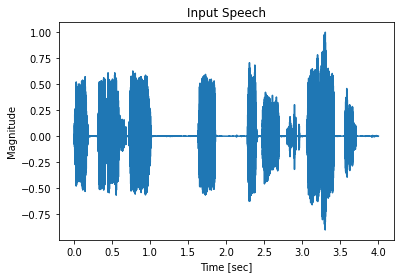

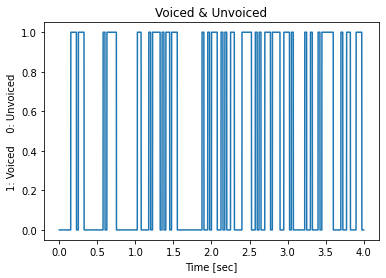

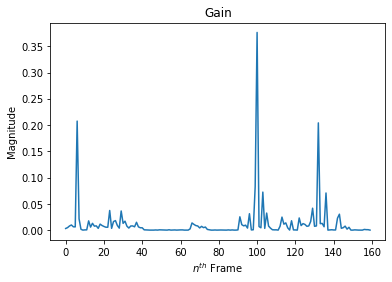

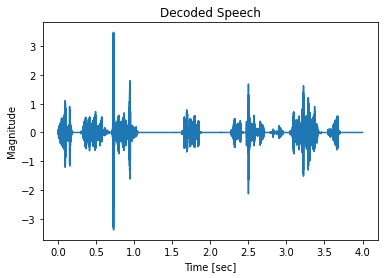

In [4]:
vocoder = LPCVocoder(path,0.025,64,3,7)
print("Input Speech: ")
display(ipd.Audio(vocoder.x, rate = vocoder.fs))
vocoder.run()
print("Decoded Speech:")
display(ipd.Audio(vocoder.decodedSpeech, rate = vocoder.fs))


Limited Decoded Speech: 


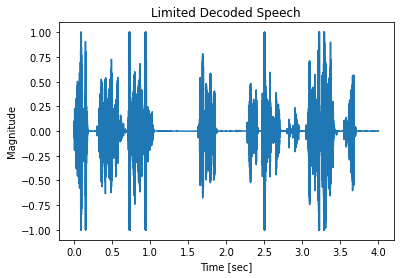

In [5]:
speech = np.copy(vocoder.decodedSpeech)
speech[speech>1] = 1 
speech[speech<-1] = -1
plt.figure()
plt.plot(np.arange(0,vocoder.totalTime,1/vocoder.fs),speech)
plt.title("Limited Decoded Speech")
plt.xlabel("Time [sec]")
plt.ylabel("Magnitude")
plt.savefig(vocoder.title + "limitedDecodedWaveform.jpg")
print("Limited Decoded Speech: ")
display(ipd.Audio(vocoder.x, rate = vocoder.fs))
sf.write(vocoder.title + "limitedDecodedSpeech.wav", speech,vocoder.fs)

In [6]:
shutil.make_archive('Results', 'zip', 'Results')
files.download('Results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>